# Полносвязные нейронные сети

In [1]:
import collections
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import notebook

In [17]:
def build_fcnn(model_id, device, n_tier, in_features, n_features, use_batchnorm=False, p_dropout=None):
    torch.manual_seed(0)
    np.random.seed(0)

    layers = collections.OrderedDict()
    layers[f'linear0'] = nn.Linear(in_features, n_features)
    if use_batchnorm:
        layers[f'batchnorm0'] = nn.BatchNorm1d(n_features)
    layers[f'relu0'] = nn.ReLU(inplace=True)
    if p_dropout:
        layers[f'dropout0'] = nn.Dropout(p_dropout)
    
    for i in range(1, n_tier):
        layers[f'linear{i}'] = nn.Linear(n_features, n_features)
        if use_batchnorm:
            layers[f'batchnorm{i}'] = nn.BatchNorm1d(n_features)
        layers[f'relu{i}'] = nn.ReLU(inplace=True)
        if p_dropout:
            layers[f'dropout{i}'] = nn.Dropout(p_dropout)
    
    layers[f'linear_out'] = nn.Linear(n_features, 1)

    net = nn.Sequential(layers).to(device)
    net.model_id = model_id
    return net


def batch_generator(X, Y, batch_size=24):
    for i in range(0, X.shape[0], batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]


def train_model(model, n_epochs, n_early_stop, X_train, Y_train, X_val, Y_val, device, verbose=False, batch_size=24):
    model_state_dict_path = f'{model.model_id}.pth'
    best_val_loss = np.inf
    best_epoch = -1
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_func = nn.MSELoss()
    train_time_seconds = 0
    i = 0
    for epoch in notebook.tqdm(range(n_epochs)):
        start = time.time()
        model.train()
        sum_loss = 0
        n = 0
        for batch_x, batch_y in batch_generator(X_train, Y_train, batch_size):
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_y = torch.from_numpy(batch_y).to(device)
            prediction = model(batch_x)

            loss = loss_func(prediction, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss * batch_x.size(0)
            n += batch_x.size(0)
        
        model.eval()
        with torch.no_grad():
            prediction = model(torch.from_numpy(X_val).to(device))
            val_loss = loss_func(prediction, torch.from_numpy(Y_val).to(device)).cpu().numpy()
        
        finish = time.time()
        train_time_seconds += finish - start

        if verbose:
            print('model_id:', model.model_id, 'epoch:', epoch, 'train_loss:', sum_loss.detach().numpy() / n, 'val_loss:', val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_state_dict_path)
            i = 0
        else:
            i += 1
            if i > n_early_stop:
                break
        
    return {'best_epoch': best_epoch, 'best_val_loss': best_val_loss.item(), 'model_state_dict_path': model_state_dict_path, 'train_time_seconds': train_time_seconds}


def features_target(data_frame):
    return data_frame[data_frame.columns[3:]].to_numpy(), data_frame['NumCases'].to_numpy()

## 1 Предсказания значений на следующий месяц по данным за предыдущий год

In [3]:
time_series = pd.read_csv('ts_features.csv').astype('float32')
time_series.head()

,Year,Month,NumCases,Relationship_Acquaintance,Relationship_Boyfriend,Relationship_Boyfriend/Girlfriend,Relationship_Brother,Relationship_Common-Law Husband,Relationship_Common-Law Wife,Relationship_Daughter,Relationship_Employee,Relationship_Employer,Relationship_Ex-Husband,Relationship_Ex-Wife,Relationship_Family,Relationship_Father,Relationship_Friend,Relationship_Girlfriend,Relationship_Husband,Relationship_In-Law,Relationship_Mother,Relationship_Neighbor,Relationship_Sister,Relationship_Son,Relationship_Stepdaughter,Relationship_Stepfather,Relationship_Stepmother,Relationship_Stepson,Relationship_Stranger,Relationship_Unknown,Relationship_Wife,Crime Solved_No,Crime Solved_Yes,Crime Type_Manslaughter by Negligence,Crime Type_Murder or Manslaughter,Victim Race_Asian/Pacific Islander,Victim Race_Black,Victim Race_Native American/Alaska Native,Victim Race_Unknown,Victim Race_White,...,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhodes Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Perpetrator Race_Asian/Pacific Islander,Perpetrator Race_Black,Perpetrator Race_Native American/Alaska Native,Perpetrator Race_Unknown,Perpetrator Race_White,Perpetrator Count,Victim Count
0,1980.0,1.0,1825.0,434.0,18.0,1.0,25.0,16.0,9.0,19.0,0.0,1.0,5.0,6.0,23.0,14.0,59.0,34.0,49.0,21.0,10.0,13.0,6.0,32.0,1.0,6.0,1.0,3.0,281.0,671.0,67.0,483.0,1342.0,24.0,1801.0,14.0,749.0,11.0,60.0,991.0,...,38.0,1.0,35.0,20.0,79.0,7.0,14.0,36.0,1.0,5.0,15.0,0.0,39.0,18.0,177.0,59.0,2.0,51.0,28.0,11.0,48.0,3.0,30.0,0.0,34.0,187.0,4.0,1.0,23.0,23.0,9.0,11.0,1.0,6.0,616.0,8.0,515.0,680.0,398.0,228.0
1,1980.0,2.0,1730.0,407.0,21.0,5.0,9.0,9.0,15.0,25.0,1.0,0.0,0.0,3.0,23.0,11.0,64.0,37.0,52.0,17.0,11.0,21.0,3.0,43.0,3.0,8.0,0.0,2.0,301.0,577.0,62.0,462.0,1268.0,20.0,1710.0,19.0,750.0,7.0,45.0,909.0,...,58.0,6.0,33.0,20.0,67.0,6.0,18.0,46.0,1.0,2.0,5.0,1.0,33.0,34.0,165.0,49.0,2.0,79.0,19.0,9.0,43.0,3.0,28.0,1.0,34.0,199.0,6.0,1.0,33.0,11.0,10.0,12.0,3.0,8.0,630.0,8.0,497.0,587.0,328.0,164.0
2,1980.0,3.0,1743.0,403.0,17.0,0.0,20.0,18.0,7.0,11.0,0.0,1.0,5.0,5.0,22.0,19.0,63.0,26.0,54.0,17.0,5.0,35.0,7.0,22.0,2.0,5.0,0.0,8.0,292.0,617.0,62.0,492.0,1251.0,27.0,1716.0,18.0,756.0,8.0,46.0,915.0,...,53.0,0.0,31.0,23.0,71.0,7.0,13.0,29.0,0.0,5.0,18.0,0.0,40.0,9.0,148.0,48.0,2.0,74.0,17.0,19.0,63.0,3.0,24.0,0.0,39.0,231.0,4.0,0.0,36.0,18.0,6.0,16.0,3.0,13.0,625.0,10.0,513.0,582.0,292.0,160.0
3,1980.0,4.0,1760.0,430.0,26.0,1.0,26.0,17.0,10.0,17.0,4.0,1.0,3.0,8.0,28.0,17.0,64.0,27.0,41.0,18.0,10.0,23.0,4.0,10.0,2.0,5.0,0.0,7.0,270.0,599.0,92.0,462.0,1298.0,16.0,1744.0,12.0,757.0,9.0,55.0,927.0,...,36.0,2.0,29.0,17.0,56.0,9.0,19.0,36.0,4.0,6.0,10.0,5.0,43.0,14.0,177.0,53.0,0.0,82.0,26.0,12.0,49.0,5.0,31.0,0.0,40.0,203.0,1.0,0.0,32.0,16.0,4.0,13.0,2.0,11.0,610.0,7.0,495.0,637.0,328.0,194.0
4,1980.0,5.0,1863.0,461.0,27.0,2.0,21.0,14.0,14.0,11.0,1.0,0.0,4.0,3.0,21.0,14.0,67.0,35.0,50.0,19.0,12.0,24.0,3.0,29.0,2.0,5.0,0.0,7.0,296.0,634.0,87.0,510.0,1353.0,26.0,1837.0,9.0,822.0,14.0,62.0,956.0,...,41.0,4.0,36.0,16.0,96.0,12.0,15.0,53.0,2.0,5.0,4.0,1.0,38.0,12.0,183.0,37.0,3.0,61.0,26.0,12.0,69.0,1.0,32.0,2.0,47.0,184.0,5.0,0.0,43.0,20.0,14.0,12.0,1.0,12.0,659.0,11.0,551.0,630.0,290.0,208.0


In [4]:
tmp = time_series[time_series.columns[:3]].copy()
for column in time_series.columns[2:]:
    for i in range(1, 13, 1):
        tmp[f'{column}_{i}'] = time_series[column].shift(i)

time_series = tmp

In [5]:
print(f'Number of features: {len(time_series.columns[3:])}')

Number of features: 1416


In [6]:
time_series = time_series[12:]
time_series.head()

,Year,Month,NumCases,NumCases_1,NumCases_2,NumCases_3,NumCases_4,NumCases_5,NumCases_6,NumCases_7,NumCases_8,NumCases_9,NumCases_10,NumCases_11,NumCases_12,Relationship_Acquaintance_1,Relationship_Acquaintance_2,Relationship_Acquaintance_3,Relationship_Acquaintance_4,Relationship_Acquaintance_5,Relationship_Acquaintance_6,Relationship_Acquaintance_7,Relationship_Acquaintance_8,Relationship_Acquaintance_9,Relationship_Acquaintance_10,Relationship_Acquaintance_11,Relationship_Acquaintance_12,Relationship_Boyfriend_1,Relationship_Boyfriend_2,Relationship_Boyfriend_3,Relationship_Boyfriend_4,Relationship_Boyfriend_5,Relationship_Boyfriend_6,Relationship_Boyfriend_7,Relationship_Boyfriend_8,Relationship_Boyfriend_9,Relationship_Boyfriend_10,Relationship_Boyfriend_11,Relationship_Boyfriend_12,Relationship_Boyfriend/Girlfriend_1,...,Perpetrator Race_Unknown_9,Perpetrator Race_Unknown_10,Perpetrator Race_Unknown_11,Perpetrator Race_Unknown_12,Perpetrator Race_White_1,Perpetrator Race_White_2,Perpetrator Race_White_3,Perpetrator Race_White_4,Perpetrator Race_White_5,Perpetrator Race_White_6,Perpetrator Race_White_7,Perpetrator Race_White_8,Perpetrator Race_White_9,Perpetrator Race_White_10,Perpetrator Race_White_11,Perpetrator Race_White_12,Perpetrator Count_1,Perpetrator Count_2,Perpetrator Count_3,Perpetrator Count_4,Perpetrator Count_5,Perpetrator Count_6,Perpetrator Count_7,Perpetrator Count_8,Perpetrator Count_9,Perpetrator Count_10,Perpetrator Count_11,Perpetrator Count_12,Victim Count_1,Victim Count_2,Victim Count_3,Victim Count_4,Victim Count_5,Victim Count_6,Victim Count_7,Victim Count_8,Victim Count_9,Victim Count_10,Victim Count_11,Victim Count_12
12,1981.0,1.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0,1825.0,430.0,398.0,449.0,483.0,577.0,553.0,474.0,461.0,430.0,403.0,407.0,434.0,18.0,24.0,30.0,19.0,27.0,33.0,25.0,27.0,26.0,17.0,21.0,18.0,1.0,...,495.0,513.0,497.0,515.0,673.0,637.0,657.0,736.0,846.0,811.0,690.0,630.0,637.0,582.0,587.0,680.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,292.0,328.0,398.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0,160.0,164.0,228.0
13,1981.0,2.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0,520.0,430.0,398.0,449.0,483.0,577.0,553.0,474.0,461.0,430.0,403.0,407.0,20.0,18.0,24.0,30.0,19.0,27.0,33.0,25.0,27.0,26.0,17.0,21.0,2.0,...,551.0,495.0,513.0,497.0,740.0,673.0,637.0,657.0,736.0,846.0,811.0,690.0,630.0,637.0,582.0,587.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,292.0,328.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0,160.0,164.0
14,1981.0,3.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,405.0,520.0,430.0,398.0,449.0,483.0,577.0,553.0,474.0,461.0,430.0,403.0,27.0,20.0,18.0,24.0,30.0,19.0,27.0,33.0,25.0,27.0,26.0,17.0,2.0,...,594.0,551.0,495.0,513.0,627.0,740.0,673.0,637.0,657.0,736.0,846.0,811.0,690.0,630.0,637.0,582.0,247.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,292.0,216.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0,160.0
15,1981.0,4.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,475.0,405.0,520.0,430.0,398.0,449.0,483.0,577.0,553.0,474.0,461.0,430.0,13.0,27.0,20.0,18.0,24.0,30.0,19.0,27.0,33.0,25.0,27.0,26.0,5.0,...,560.0,594.0,551.0,495.0,710.0,627.0,740.0,673.0,637.0,657.0,736.0,846.0,811.0,690.0,630.0,637.0,315.0,247.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,226.0,216.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0
16,1981.0,5.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,422.0,475.0,405.0,520.0,430.0,398.0,449.0,483.0,577.0,553.0,474.0,461.0,28.0,13.0,27.0,20.0,18.0,24.0,30.0,19.0,27.0,33.0,25.0,27.0,8.0,...,684.0,560.0,594.0,551.0,693.0,710.0,627.0,740.0,673.0,637.0,657.0,736.0,846.0,811.0,690.0,630.0,241.0,315.0,247.0,315.0,297.0,281.0,362.0

In [7]:
test = time_series[-60:]
train = time_series[:-60]
val = train[-60:]
train = train[:-60]

train.shape, val.shape, test.shape

((288, 1419), (60, 1419), (60, 1419))

In [8]:
X_train, Y_train = features_target(train)
X_val, Y_val = features_target(val)
X_test, Y_test = features_target(test)

In [9]:
scaler_x = sklearn.preprocessing.StandardScaler()
scaler_y = sklearn.preprocessing.StandardScaler()

X_train = scaler_x.fit_transform(X_train)
Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1))

X_val = scaler_x.transform(X_val)
Y_val = scaler_y.transform(Y_val.reshape(-1, 1))

X_test = scaler_x.transform(X_test)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
N_EPOCHS = 10000
N_EARLY_STOP = 1000

### 1.1 Двухслойные модели

In [11]:
fcnn_2_layers_no_batchnorm_no_dropout = build_fcnn('fcnn_2_layers_no_batchnorm_no_dropout', device, n_tier=1, in_features=X_train.shape[1], n_features=64)
print(fcnn_2_layers_no_batchnorm_no_dropout)
train_model(fcnn_2_layers_no_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 11,
 'best_val_loss': 0.14638113975524902,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_no_dropout.pth',
 'train_time_seconds': 23.479191541671753}

In [12]:
fcnn_2_layers_batchnorm_no_dropout = build_fcnn('fcnn_2_layers_batchnorm_no_dropout', device, n_tier=1, in_features=X_train.shape[1], n_features=64, use_batchnorm=True)
print(fcnn_2_layers_batchnorm_no_dropout)
train_model(fcnn_2_layers_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (batchnorm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 1,
 'best_val_loss': 0.3838510513305664,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_no_dropout.pth',
 'train_time_seconds': 36.060545444488525}

In [13]:
fcnn_2_layers_no_batchnorm_dropout = build_fcnn('fcnn_2_layers_no_batchnorm_dropout', device, n_tier=1, in_features=X_train.shape[1], n_features=64, use_batchnorm=False, p_dropout=0.5)
print(fcnn_2_layers_no_batchnorm_dropout)
train_model(fcnn_2_layers_no_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 26,
 'best_val_loss': 0.14979703724384308,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_dropout.pth',
 'train_time_seconds': 25.33405375480652}

In [14]:
fcnn_2_layers_batchnorm_dropout = build_fcnn('fcnn_2_layers_batchnorm_dropout', device, n_tier=1, in_features=X_train.shape[1], n_features=64, use_batchnorm=True, p_dropout=0.5)
print(fcnn_2_layers_batchnorm_dropout)
train_model(fcnn_2_layers_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (batchnorm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 2,
 'best_val_loss': 0.31020253896713257,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_dropout.pth',
 'train_time_seconds': 37.40572166442871}

### 1.2 Трёхслойные модели

In [18]:
fcnn_3_layers_no_batchnorm_no_dropout = build_fcnn('fcnn_3_layers_no_batchnorm_no_dropout', device, n_tier=2, in_features=X_train.shape[1], n_features=64)
print(fcnn_3_layers_no_batchnorm_no_dropout)
train_model(fcnn_3_layers_no_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 660,
 'best_val_loss': 0.1702711284160614,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_no_dropout.pth',
 'train_time_seconds': 45.68004512786865}

In [19]:
fcnn_3_layers_batchnorm_no_dropout = build_fcnn('fcnn_3_layers_batchnorm_no_dropout', device, n_tier=2, in_features=X_train.shape[1], n_features=64, use_batchnorm=True)
print(fcnn_3_layers_batchnorm_no_dropout)
train_model(fcnn_3_layers_batchnorm_no_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (batchnorm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 893,
 'best_val_loss': 0.4463694989681244,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_no_dropout.pth',
 'train_time_seconds': 99.03866910934448}

In [20]:
fcnn_3_layers_no_batchnorm_dropout = build_fcnn('fcnn_3_layers_no_batchnorm_dropout', device, n_tier=2, in_features=X_train.shape[1], n_features=64, use_batchnorm=False, p_dropout=0.5)
print(fcnn_3_layers_no_batchnorm_dropout)
train_model(fcnn_3_layers_no_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 55,
 'best_val_loss': 0.1699402630329132,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_dropout.pth',
 'train_time_seconds': 31.76997971534729}

In [21]:
fcnn_3_layers_batchnorm_dropout = build_fcnn('fcnn_3_layers_batchnorm_dropout', device, n_tier=2, in_features=X_train.shape[1], n_features=64, use_batchnorm=True, p_dropout=0.5)
print(fcnn_3_layers_batchnorm_dropout)
train_model(fcnn_3_layers_batchnorm_dropout, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (batchnorm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)


{'best_epoch': 12,
 'best_val_loss': 0.4717082381248474,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_dropout.pth',
 'train_time_seconds': 55.91954851150513}

### 1.3 Лучшая модель на данных за предыдущий года

In [24]:
best_model_12months = build_fcnn('fcnn_2_layers_no_batchnorm_no_dropout', device, n_tier=1, in_features=X_train.shape[1], n_features=64)
best_model_12months.load_state_dict(torch.load('fcnn_2_layers_no_batchnorm_no_dropout.pth'))
best_model_12months.eval()

Sequential(
  (linear0): Linear(in_features=1416, out_features=64, bias=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
with torch.no_grad():
    Y_predict_scaled = best_model_12months(torch.from_numpy(X_test).to(device)).numpy()

Y_predict = scaler_y.inverse_transform(Y_predict_scaled).squeeze()

In [26]:
print('RMSE:', sklearn.metrics.mean_squared_error(Y_test, Y_predict, squared=False))

RMSE: 126.62037


In [27]:
prediction = [np.nan] * time_series.shape[0]
prediction[-60:] = Y_predict
time_series['NumCases_predict'] = prediction
time_series['Date'] = time_series['Year'] + (time_series['Month'] - 1) / 12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


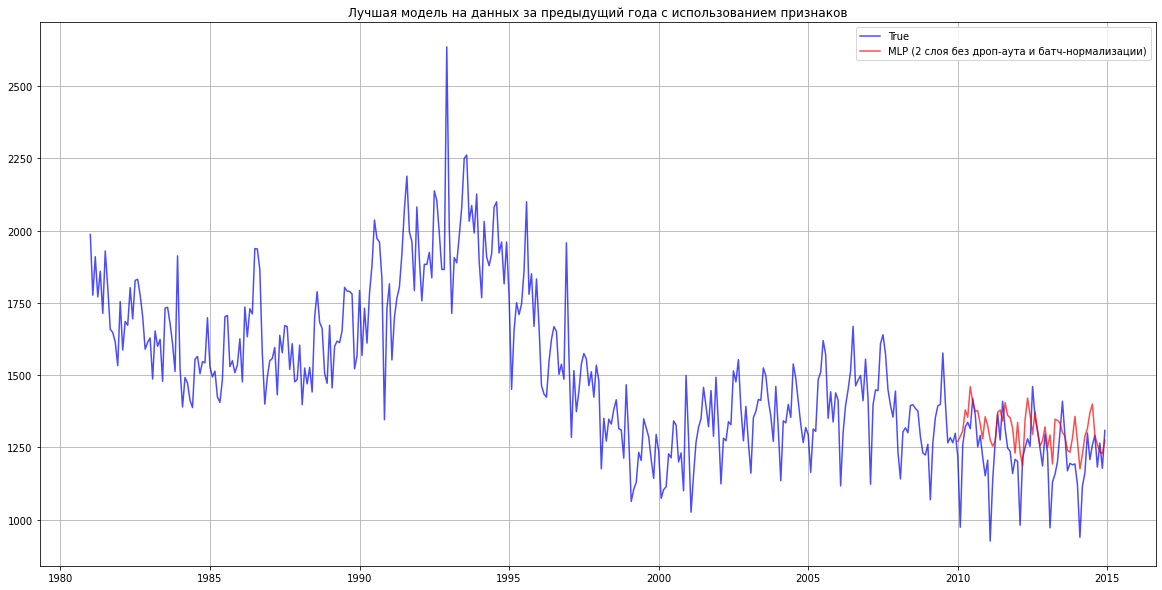

In [28]:
plt.figure(figsize=(20,10)) 
plt.plot(time_series['Date'], time_series['NumCases'], color='b', alpha=0.7, label="True")
plt.plot(time_series['Date'][-60:], time_series['NumCases_predict'][-60:], color='r', alpha=0.7, label="MLP (2 слоя без дроп-аута и батч-нормализации)")
plt.title('Лучшая модель на данных за предыдущий года с использованием признаков')
plt.grid()
plt.legend()
plt.show()

**RMSE: 126.62037**
#### Быстродействие

In [29]:
spans = []
with torch.no_grad():
    for i in range(101):
        start = time.time()
        best_model_12months(torch.from_numpy(X_test).to(device)).numpy()
        finish = time.time()
        spans.append(finish - start)

spans = np.asarray(spans[1:])
print('Mean predict time:', spans.mean(), 'Std:', spans.std(ddof=1))

Mean predict time: 0.0008418893814086914 Std: 0.00021774042609453608


## 2 Предсказания значений на следующий месяц по данным за 2 предыдущих года

In [30]:
time_series = pd.read_csv('ts_features.csv').astype('float32')
time_series.head()

,Year,Month,NumCases,Relationship_Acquaintance,Relationship_Boyfriend,Relationship_Boyfriend/Girlfriend,Relationship_Brother,Relationship_Common-Law Husband,Relationship_Common-Law Wife,Relationship_Daughter,Relationship_Employee,Relationship_Employer,Relationship_Ex-Husband,Relationship_Ex-Wife,Relationship_Family,Relationship_Father,Relationship_Friend,Relationship_Girlfriend,Relationship_Husband,Relationship_In-Law,Relationship_Mother,Relationship_Neighbor,Relationship_Sister,Relationship_Son,Relationship_Stepdaughter,Relationship_Stepfather,Relationship_Stepmother,Relationship_Stepson,Relationship_Stranger,Relationship_Unknown,Relationship_Wife,Crime Solved_No,Crime Solved_Yes,Crime Type_Manslaughter by Negligence,Crime Type_Murder or Manslaughter,Victim Race_Asian/Pacific Islander,Victim Race_Black,Victim Race_Native American/Alaska Native,Victim Race_Unknown,Victim Race_White,...,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhodes Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Perpetrator Race_Asian/Pacific Islander,Perpetrator Race_Black,Perpetrator Race_Native American/Alaska Native,Perpetrator Race_Unknown,Perpetrator Race_White,Perpetrator Count,Victim Count
0,1980.0,1.0,1825.0,434.0,18.0,1.0,25.0,16.0,9.0,19.0,0.0,1.0,5.0,6.0,23.0,14.0,59.0,34.0,49.0,21.0,10.0,13.0,6.0,32.0,1.0,6.0,1.0,3.0,281.0,671.0,67.0,483.0,1342.0,24.0,1801.0,14.0,749.0,11.0,60.0,991.0,...,38.0,1.0,35.0,20.0,79.0,7.0,14.0,36.0,1.0,5.0,15.0,0.0,39.0,18.0,177.0,59.0,2.0,51.0,28.0,11.0,48.0,3.0,30.0,0.0,34.0,187.0,4.0,1.0,23.0,23.0,9.0,11.0,1.0,6.0,616.0,8.0,515.0,680.0,398.0,228.0
1,1980.0,2.0,1730.0,407.0,21.0,5.0,9.0,9.0,15.0,25.0,1.0,0.0,0.0,3.0,23.0,11.0,64.0,37.0,52.0,17.0,11.0,21.0,3.0,43.0,3.0,8.0,0.0,2.0,301.0,577.0,62.0,462.0,1268.0,20.0,1710.0,19.0,750.0,7.0,45.0,909.0,...,58.0,6.0,33.0,20.0,67.0,6.0,18.0,46.0,1.0,2.0,5.0,1.0,33.0,34.0,165.0,49.0,2.0,79.0,19.0,9.0,43.0,3.0,28.0,1.0,34.0,199.0,6.0,1.0,33.0,11.0,10.0,12.0,3.0,8.0,630.0,8.0,497.0,587.0,328.0,164.0
2,1980.0,3.0,1743.0,403.0,17.0,0.0,20.0,18.0,7.0,11.0,0.0,1.0,5.0,5.0,22.0,19.0,63.0,26.0,54.0,17.0,5.0,35.0,7.0,22.0,2.0,5.0,0.0,8.0,292.0,617.0,62.0,492.0,1251.0,27.0,1716.0,18.0,756.0,8.0,46.0,915.0,...,53.0,0.0,31.0,23.0,71.0,7.0,13.0,29.0,0.0,5.0,18.0,0.0,40.0,9.0,148.0,48.0,2.0,74.0,17.0,19.0,63.0,3.0,24.0,0.0,39.0,231.0,4.0,0.0,36.0,18.0,6.0,16.0,3.0,13.0,625.0,10.0,513.0,582.0,292.0,160.0
3,1980.0,4.0,1760.0,430.0,26.0,1.0,26.0,17.0,10.0,17.0,4.0,1.0,3.0,8.0,28.0,17.0,64.0,27.0,41.0,18.0,10.0,23.0,4.0,10.0,2.0,5.0,0.0,7.0,270.0,599.0,92.0,462.0,1298.0,16.0,1744.0,12.0,757.0,9.0,55.0,927.0,...,36.0,2.0,29.0,17.0,56.0,9.0,19.0,36.0,4.0,6.0,10.0,5.0,43.0,14.0,177.0,53.0,0.0,82.0,26.0,12.0,49.0,5.0,31.0,0.0,40.0,203.0,1.0,0.0,32.0,16.0,4.0,13.0,2.0,11.0,610.0,7.0,495.0,637.0,328.0,194.0
4,1980.0,5.0,1863.0,461.0,27.0,2.0,21.0,14.0,14.0,11.0,1.0,0.0,4.0,3.0,21.0,14.0,67.0,35.0,50.0,19.0,12.0,24.0,3.0,29.0,2.0,5.0,0.0,7.0,296.0,634.0,87.0,510.0,1353.0,26.0,1837.0,9.0,822.0,14.0,62.0,956.0,...,41.0,4.0,36.0,16.0,96.0,12.0,15.0,53.0,2.0,5.0,4.0,1.0,38.0,12.0,183.0,37.0,3.0,61.0,26.0,12.0,69.0,1.0,32.0,2.0,47.0,184.0,5.0,0.0,43.0,20.0,14.0,12.0,1.0,12.0,659.0,11.0,551.0,630.0,290.0,208.0


In [31]:
tmp = time_series[time_series.columns[:3]].copy()
for column in time_series.columns[2:]:
    for i in range(1, 25, 1):
        tmp[f'{column}_{i}'] = time_series[column].shift(i)

time_series = tmp

In [32]:
print(f'Number of features: {len(time_series.columns[3:])}')

Number of features: 2832


In [33]:
time_series = time_series[24:]
time_series.head()

,Year,Month,NumCases,NumCases_1,NumCases_2,NumCases_3,NumCases_4,NumCases_5,NumCases_6,NumCases_7,NumCases_8,NumCases_9,NumCases_10,NumCases_11,NumCases_12,NumCases_13,NumCases_14,NumCases_15,NumCases_16,NumCases_17,NumCases_18,NumCases_19,NumCases_20,NumCases_21,NumCases_22,NumCases_23,NumCases_24,Relationship_Acquaintance_1,Relationship_Acquaintance_2,Relationship_Acquaintance_3,Relationship_Acquaintance_4,Relationship_Acquaintance_5,Relationship_Acquaintance_6,Relationship_Acquaintance_7,Relationship_Acquaintance_8,Relationship_Acquaintance_9,Relationship_Acquaintance_10,Relationship_Acquaintance_11,Relationship_Acquaintance_12,Relationship_Acquaintance_13,...,Perpetrator Count_9,Perpetrator Count_10,Perpetrator Count_11,Perpetrator Count_12,Perpetrator Count_13,Perpetrator Count_14,Perpetrator Count_15,Perpetrator Count_16,Perpetrator Count_17,Perpetrator Count_18,Perpetrator Count_19,Perpetrator Count_20,Perpetrator Count_21,Perpetrator Count_22,Perpetrator Count_23,Perpetrator Count_24,Victim Count_1,Victim Count_2,Victim Count_3,Victim Count_4,Victim Count_5,Victim Count_6,Victim Count_7,Victim Count_8,Victim Count_9,Victim Count_10,Victim Count_11,Victim Count_12,Victim Count_13,Victim Count_14,Victim Count_15,Victim Count_16,Victim Count_17,Victim Count_18,Victim Count_19,Victim Count_20,Victim Count_21,Victim Count_22,Victim Count_23,Victim Count_24
24,1982.0,1.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0,1825.0,370.0,382.0,457.0,433.0,484.0,456.0,462.0,458.0,422.0,475.0,405.0,520.0,430.0,...,241.0,315.0,247.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,292.0,328.0,398.0,134.0,164.0,164.0,108.0,116.0,206.0,150.0,222.0,176.0,226.0,216.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0,160.0,164.0,228.0
25,1982.0,2.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,1730.0,431.0,370.0,382.0,457.0,433.0,484.0,456.0,462.0,458.0,422.0,475.0,405.0,520.0,...,213.0,241.0,315.0,247.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,292.0,328.0,180.0,134.0,164.0,164.0,108.0,116.0,206.0,150.0,222.0,176.0,226.0,216.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0,160.0,164.0
26,1982.0,3.0,1686.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,1743.0,392.0,431.0,370.0,382.0,457.0,433.0,484.0,456.0,462.0,458.0,422.0,475.0,405.0,...,208.0,213.0,241.0,315.0,247.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,292.0,172.0,180.0,134.0,164.0,164.0,108.0,116.0,206.0,150.0,222.0,176.0,226.0,216.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0,160.0
27,1982.0,4.0,1673.0,1686.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,1760.0,417.0,392.0,431.0,370.0,382.0,457.0,433.0,484.0,456.0,462.0,458.0,422.0,475.0,...,277.0,208.0,213.0,241.0,315.0,247.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,328.0,224.0,172.0,180.0,134.0,164.0,164.0,108.0,116.0,206.0,150.0,222.0,176.0,226.0,216.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0,194.0
28,1982.0,5.0,1803.0,1673.0,1686.0,1587.0,1755.0,1533.0,1615.0,1648.0,1659.0,1804.0,1930.0,1714.0,1860.0,1771.0,1910.0,1777.0,1987.0,1965.0,1861.0,1935.0,1869.0,2371.0,2179.0,1991.0,1863.0,397.0,417.0,392.0,431.0,370.0,382.0,457.0,433.0,484.0,456.0,462.0,458.0,422.0,...,214.0,277.0,208.0,213.0,241.0,315.0,247.0,315.0,297.0,281.0,362.0,361.0,477.0,464.0,359.0,290.0,204.0,224.0,172.0,180.0,134.0,164.0,164.0,108.0,116.0,206.0,150.0,222.0,176.0,226.0,216.0,236.0,378.0,188.0,146.0,190.0,178.0,208.0,168.0,208.0


In [34]:
test = time_series[-60:]
train = time_series[:-60]
val = train[-60:]
train = train[:-60]

train.shape, val.shape, test.shape

((276, 2835), (60, 2835), (60, 2835))

In [35]:
X_train, Y_train = features_target(train)
X_val, Y_val = features_target(val)
X_test, Y_test = features_target(test)

In [36]:
scaler_x = sklearn.preprocessing.StandardScaler()
scaler_y = sklearn.preprocessing.StandardScaler()

X_train = scaler_x.fit_transform(X_train)
Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1))

X_val = scaler_x.transform(X_val)
Y_val = scaler_y.transform(Y_val.reshape(-1, 1))

X_test = scaler_x.transform(X_test)

### 2.1 Двухслойные модели

In [37]:
fcnn_2_layers_no_batchnorm_no_dropout_24_months = build_fcnn('fcnn_2_layers_no_batchnorm_no_dropout_24_months', device, n_tier=1, in_features=X_train.shape[1], n_features=96)
print(fcnn_2_layers_no_batchnorm_no_dropout_24_months)
train_model(fcnn_2_layers_no_batchnorm_no_dropout_24_months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 31,
 'best_val_loss': 0.14466093480587006,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_no_dropout_24_months.pth',
 'train_time_seconds': 48.8461709022522}

In [38]:
fcnn_2_layers_batchnorm_no_dropout_24months = build_fcnn('fcnn_2_layers_batchnorm_no_dropout_24months', device, n_tier=1, in_features=X_train.shape[1], n_features=96, use_batchnorm=True)
print(fcnn_2_layers_batchnorm_no_dropout_24months)
train_model(fcnn_2_layers_batchnorm_no_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (batchnorm0): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 1152,
 'best_val_loss': 0.4907919466495514,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_no_dropout_24months.pth',
 'train_time_seconds': 138.98832941055298}

In [39]:
fcnn_2_layers_no_batchnorm_dropout_24months = build_fcnn('fcnn_2_layers_no_batchnorm_dropout_24months', device, n_tier=1, in_features=X_train.shape[1], n_features=96, use_batchnorm=False, p_dropout=0.5)
print(fcnn_2_layers_no_batchnorm_dropout_24months)
train_model(fcnn_2_layers_no_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 2018,
 'best_val_loss': 0.10946404933929443,
 'model_state_dict_path': 'fcnn_2_layers_no_batchnorm_dropout_24months.pth',
 'train_time_seconds': 147.882141828537}

In [40]:
fcnn_2_layers_batchnorm_dropout_24months = build_fcnn('fcnn_2_layers_batchnorm_dropout_24months', device, n_tier=1, in_features=X_train.shape[1], n_features=96, use_batchnorm=True, p_dropout=0.5)
print(fcnn_2_layers_batchnorm_dropout_24months)
train_model(fcnn_2_layers_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (batchnorm0): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 41,
 'best_val_loss': 0.6097460985183716,
 'model_state_dict_path': 'fcnn_2_layers_batchnorm_dropout_24months.pth',
 'train_time_seconds': 69.46634936332703}

### 2.2 Трёхслойные модели

In [41]:
fcnn_3_layers_no_batchnorm_no_dropout_24_months = build_fcnn('fcnn_3_layers_no_batchnorm_no_dropout_24_months', device, n_tier=2, in_features=X_train.shape[1], n_features=96)
print(fcnn_3_layers_no_batchnorm_no_dropout_24_months)
train_model(fcnn_3_layers_no_batchnorm_no_dropout_24_months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=96, out_features=96, bias=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 17,
 'best_val_loss': 0.1195654422044754,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_no_dropout_24_months.pth',
 'train_time_seconds': 53.76982259750366}

In [42]:
fcnn_3_layers_batchnorm_no_dropout_24months = build_fcnn('fcnn_3_layers_batchnorm_no_dropout_24months', device, n_tier=2, in_features=X_train.shape[1], n_features=96, use_batchnorm=True)
print(fcnn_3_layers_batchnorm_no_dropout_24months)
train_model(fcnn_3_layers_batchnorm_no_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (batchnorm0): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (linear1): Linear(in_features=96, out_features=96, bias=True)
  (batchnorm1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 2003,
 'best_val_loss': 0.6461275815963745,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_no_dropout_24months.pth',
 'train_time_seconds': 259.12849617004395}

In [43]:
fcnn_3_layers_no_batchnorm_dropout_24months = build_fcnn('fcnn_3_layers_no_batchnorm_dropout_24months', device, n_tier=2, in_features=X_train.shape[1], n_features=96, use_batchnorm=False, p_dropout=0.5)
print(fcnn_3_layers_no_batchnorm_dropout_24months)
train_model(fcnn_3_layers_no_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=96, out_features=96, bias=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 71,
 'best_val_loss': 0.11643899232149124,
 'model_state_dict_path': 'fcnn_3_layers_no_batchnorm_dropout_24months.pth',
 'train_time_seconds': 60.180546045303345}

In [44]:
fcnn_3_layers_batchnorm_dropout_24months = build_fcnn('fcnn_3_layers_batchnorm_dropout_24months', device, n_tier=2, in_features=X_train.shape[1], n_features=96, use_batchnorm=True, p_dropout=0.5)
print(fcnn_3_layers_batchnorm_dropout_24months)
train_model(fcnn_3_layers_batchnorm_dropout_24months, N_EPOCHS, N_EARLY_STOP, X_train, Y_train, X_val, Y_val, device)

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (batchnorm0): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=96, out_features=96, bias=True)
  (batchnorm1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)


{'best_epoch': 695,
 'best_val_loss': 0.3992461562156677,
 'model_state_dict_path': 'fcnn_3_layers_batchnorm_dropout_24months.pth',
 'train_time_seconds': 151.66269040107727}

### 2.3 Лучшая модель на данных за два предыдущих года

In [45]:
best_model_24months = build_fcnn('fcnn_2_layers_no_batchnorm_dropout_24months', device, n_tier=1, in_features=X_train.shape[1], n_features=96, use_batchnorm=False, p_dropout=0.5)
best_model_24months.load_state_dict(torch.load('fcnn_2_layers_no_batchnorm_dropout_24months.pth'))
best_model_24months.eval()

Sequential(
  (linear0): Linear(in_features=2832, out_features=96, bias=True)
  (relu0): ReLU(inplace=True)
  (dropout0): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=96, out_features=1, bias=True)
)

In [46]:
with torch.no_grad():
    Y_predict_scaled = best_model_24months(torch.from_numpy(X_test).to(device)).numpy()

Y_predict = scaler_y.inverse_transform(Y_predict_scaled).squeeze()

In [47]:
print('RMSE:', sklearn.metrics.mean_squared_error(Y_test, Y_predict, squared=False))

RMSE: 117.36313


In [48]:
prediction = [np.nan] * time_series.shape[0]
prediction[-60:] = Y_predict
time_series['NumCases_predict'] = prediction
time_series['Date'] = time_series['Year'] + (time_series['Month'] - 1) / 12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


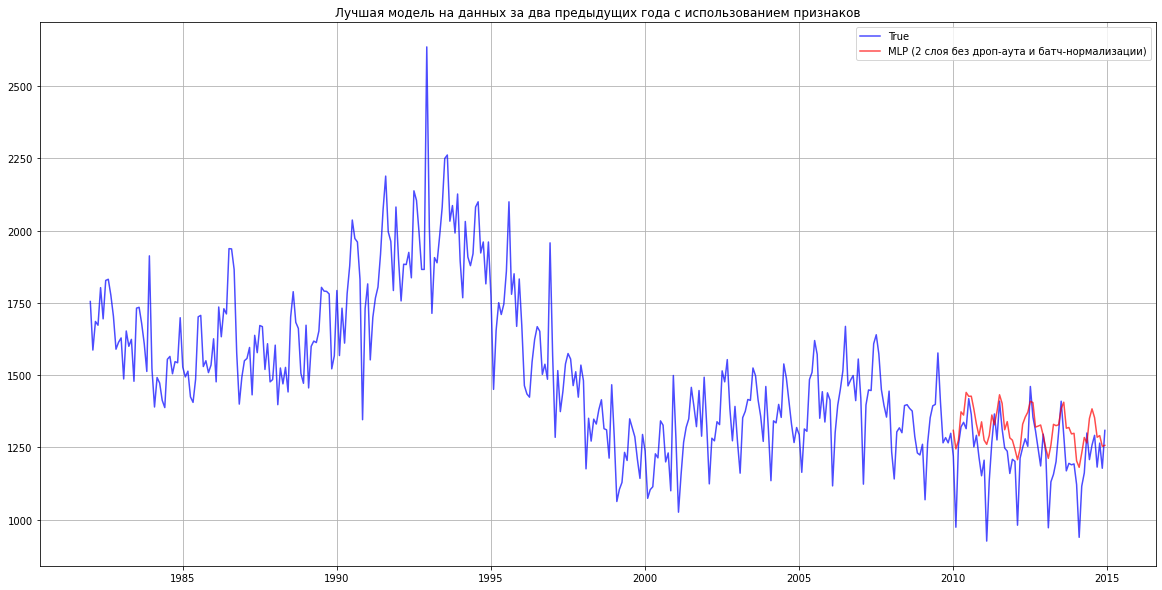

In [50]:
plt.figure(figsize=(20,10)) 
plt.plot(time_series['Date'], time_series['NumCases'], color='b', alpha=0.7, label="True")
plt.plot(time_series['Date'][-60:], time_series['NumCases_predict'][-60:], color='r', alpha=0.7, label="MLP (2 слоя без дроп-аута и батч-нормализации)")
plt.title('Лучшая модель на данных за два предыдущих года с использованием признаков')
plt.grid()
plt.legend()
plt.show()

**RMSE: 117.36313**
#### Быстродействие

In [51]:
spans = []
with torch.no_grad():
    for i in range(101):
        start = time.time()
        best_model_24months(torch.from_numpy(X_test).to(device)).numpy()
        finish = time.time()
        spans.append(finish - start)

spans = np.asarray(spans[1:])
print('Mean predict time:', spans.mean(), 'Std:', spans.std(ddof=1))

Mean predict time: 0.0022177672386169433 Std: 0.00013319556662504882


## 3 Результаты
 - Лучшей моделью, предсказывающей количество убийств на следующий месяц по данным за предыдущий год, оказалась полносвязная нейронная сеть с двумя слоями без дроп-аута и батч-нормализации. Значение метрики RMSE на тестовой выборке: 126.62037. Время обучения на 1031 эпохах - 23.5 секунды. Время предсказания на тестовой выборе - 0.0008 секунды.
 - Лучшей моделью, предсказывающей количество убийств на следующий месяц по данным за предыдущий год, оказалась полносвязная нейронная сеть с двумя слоями с дроп-аута и без батч-нормализации. Значение метрики RMSE на тестовой выборке: 117.36313. Время обучения на 2018 эпохах - 147.8 секунд. Время предсказания на тестовой выборе - 0.002 секунды.


Hardware: 2 ядра процессора Intel Xeon E5-2699 v4 2.20 ГГц, 12ГБ оперативной памяти